### ECON5140 Homework 1
#### Part 2, Problem 5

Helen Dong

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit, Probit, Poisson
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

##### Dataset 1: Customer Purchase Behavior

In [3]:
n_customers = 1000

# Generate customer features
age = np.random.normal(35, 10, n_customers)
income = np.random.normal(50, 15, n_customers) # in thousands
time_on_site = np.random.gamma(2, 3, n_customers) # in minutes

# True relationship (latent variable)
z = -3 + 0.05*age + 0.04*income + 0.15*time_on_site + np.random.normal(0, 1, n_customers)

# Generate binary outcome (Purchase: 1=Yes, 0=No)
purchase = (z > 0).astype(int)

# Create DataFrame
df_customers = pd.DataFrame({
'Age': age,
'Income': income,
'TimeOnSite': time_on_site,
'Purchase': purchase
})

print(f"Number of customers: {len(df_customers)}")
print(f"Purchase rate: {df_customers['Purchase'].mean():.2%}")
print(f"\nFirst 5 rows:")
print(df_customers.head())

Number of customers: 1000
Purchase rate: 90.00%

First 5 rows:
         Age     Income  TimeOnSite  Purchase
0  39.967142  70.990332    2.814421         1
1  33.617357  63.869505    4.460907         1
2  41.476885  50.894456    0.667441         1
3  50.230299  40.295948    5.872412         1
4  32.658466  60.473350    8.012511         1


##### Dataset 2: E-commerce sales time series

In [5]:
# Create 2 years of daily data
dates = pd.date_range('2024-01-01', '2025-12-31', freq='D')
n_days = len(dates)
t = np.arange(n_days)

# Components
trend = 1000 + 2*t + 0.01*t**2
yearly_seasonal = 200 * np.sin(2*np.pi*t/365) + 150 * np.cos(2*np.pi*t/365)
weekly_seasonal = 100 * np.sin(2*np.pi*t/7)

# Special events
special_events = np.zeros(n_days)
for year in [2024, 2025]:
    # Black Friday
    bf_date = pd.Timestamp(f'{year}-11-24')
    bf_idx = (dates == bf_date)
    special_events[bf_idx] = 800
    # Christmas
    xmas_idx = (dates >= f'{year}-12-20') & (dates <= f'{year}-12-25')
    special_events[xmas_idx] = 400
    # Random noise
    noise = np.random.normal(0, 50, n_days)
    # Combine components
    sales = trend + yearly_seasonal + weekly_seasonal + special_events + noise
    sales = np.maximum(sales, 0)

# Create DataFrame
df_sales = pd.DataFrame({
'Date': dates,
'Sales': sales,
'DayOfWeek': dates.dayofweek,
'Month': dates.month,
'IsWeekend': dates.dayofweek >= 5
})

df_sales.set_index('Date', inplace=True)

print(f"Date range: {df_sales.index[0].date()} to {df_sales.index[-1].date()}")
print(f"Number of days: {len(df_sales)}")
print(f"\nSales Statistics:")
print(df_sales['Sales'].describe())

Date range: 2024-01-01 to 2025-12-31
Number of days: 731

Sales Statistics:
count     731.000000
mean     3515.098101
std      1973.038173
min      1061.388824
25%      1587.211754
50%      3304.552751
75%      4954.843016
max      8308.867019
Name: Sales, dtype: float64


#### Part A: Generalized Linear Models

##### A1: Exploratory Data Analysis (GLM)

In [15]:
# to help with comparison, split data into purchasers and non-purchasers

purch = df_customers.loc[df_customers["Purchase"] == 1]
no_purch = df_customers.loc[df_customers["Purchase"] == 0]

Text(0, 0.5, 'Time On Site')

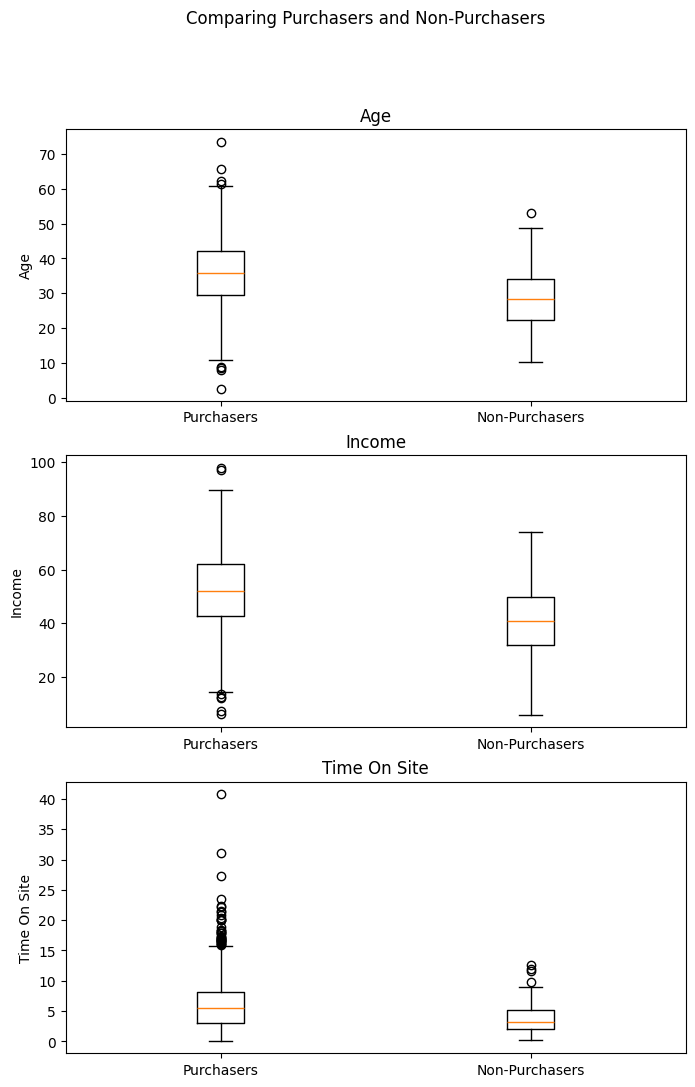

In [27]:
# box plots comparing Age, Income, and TimeOnSite between purchasers and non-purchasers (dataset 1)

fig, axs = plt.subplots(
    3, 1,
    figsize=(8, 12),
    sharex=False
)
fig.suptitle("Comparing Purchasers and Non-Purchasers")

# boxplots all set up same way, using a constructed dataframe that has purchasers data in one column and non-purchasers data in the other
axs[0].boxplot([purch["Age"], no_purch["Age"]], labels = ["Purchasers", "Non-Purchasers"])
axs[0].set_title("Age")
axs[0].set_ylabel("Age")

axs[1].boxplot([purch["Income"], no_purch["Income"]], labels = ["Purchasers", "Non-Purchasers"])
axs[1].set_title("Income")
axs[1].set_ylabel("Income")

axs[2].boxplot([purch["TimeOnSite"], no_purch["TimeOnSite"]], labels = ["Purchasers", "Non-Purchasers"])
axs[2].set_title("Time On Site")
axs[2].set_ylabel("Time On Site")

In [37]:
# mean for Age, Income, and TimeOnSite for both purchase groups

print("Purchasers:")
print(f"Mean Age: {purch["Age"].mean()}")
print(f"Mean Income: {purch["Income"].mean()}")
print(f"Mean Time On Site: {purch["TimeOnSite"].mean()}\n")
print("Non-Purchasers:")
print(f"Mean Age: {no_purch["Age"].mean()}")
print(f"Mean Income: {no_purch["Income"].mean()}")
print(f"Mean Time On Site: {no_purch["TimeOnSite"].mean()}")

Purchasers:
Mean Age: 35.91773720802165
Mean Income: 52.27476966044506
Mean Time On Site: 6.340958908866752

Non-Purchasers:
Mean Age: 28.673570710037712
Mean Income: 40.15250864336784
Mean Time On Site: 3.9254415331148773


<Axes: >

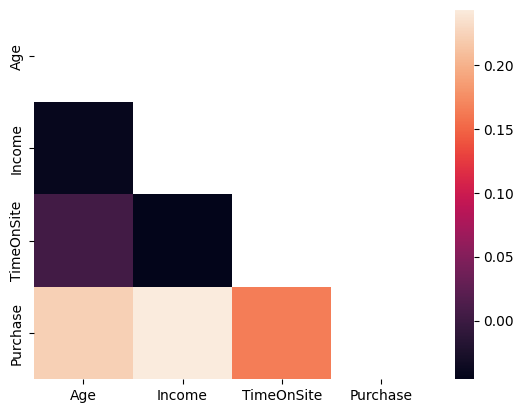

In [40]:
# correlation heatmap for overall dataframe
mask = np.triu(np.ones_like(df_customers.corr(), dtype=bool))
sns.heatmap(df_customers.corr(), mask = mask)

##### A2: Linear Probability Model

In [46]:
# for OLS, Purchase is the y variable, everything else is a predictor

y = df_customers["Purchase"]
x = df_customers[["Age", "Income", "TimeOnSite"]]

In [48]:
# add constant

x = sm.add_constant(x)

In [49]:
# fit OLS model

ols_model = sm.OLS(y, x).fit()

In [50]:
# regression summary

print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:               Purchase   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     55.67
Date:                Thu, 29 Jan 2026   Prob (F-statistic):           2.86e-33
Time:                        14:06:06   Log-Likelihood:                -137.46
No. Observations:                1000   AIC:                             282.9
Df Residuals:                     996   BIC:                             302.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3104      0.047      6.556      0.0

In [51]:
# calculate predicted probabilities

ols_pred = ols_model.predict(x)

In [55]:
# count invalid predictions

invalid = 0

for i in ols_pred:
    if i < 0 or i > 1:
        invalid += 1

In [57]:
print(f"There were {invalid} invalid predictions (predictions outside the range[0, 1]).")
print(f"Percentage of invalid predictions: {invalid/10}%")

There were 174 invalid predictions (predictions outside the range[0, 1]).
Percentage of invalid predictions: 17.4%


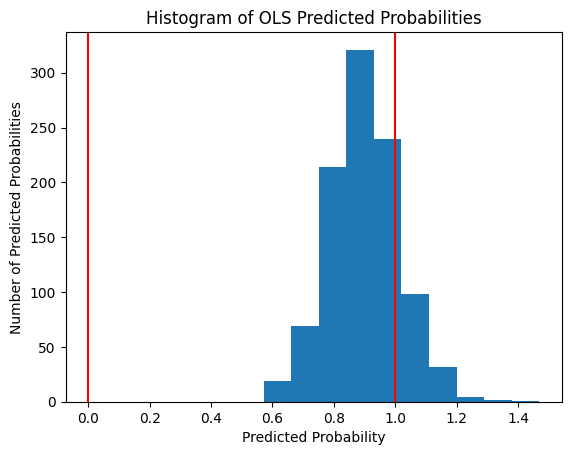

In [63]:
# histogram of predicted probabilities

plt.hist(ols_pred)
plt.title("Histogram of OLS Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Number of Predicted Probabilities")
plt.axvline(0, color = 'red')
plt.axvline(1, color = 'red')

##### A3: Logistic Regression

In [64]:
# fit logistic regression model

logit_model = sm.Logit(y, x).fit()

Optimization terminated successfully.
         Current function value: 0.238157
         Iterations 8


In [65]:
# logistic regression summary

logit_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Purchase   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      996
Method:                           MLE   Df Model:                            3
Date:                Thu, 29 Jan 2026   Pseudo R-squ.:                  0.2674
Time:                        14:18:11   Log-Likelihood:                -238.16
converged:                       True   LL-Null:                       -325.08
Covariance Type:            nonrobust   LLR p-value:                 1.874e-37
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.8737      0.715     -8.213      0.000      -7.275      -4.472
Age            0.1026      0.014      7.412      0.000       0.075       0.130
Income         0.0748      0.009      8.294      0.000       0.057       0.092
TimeOnSite     0.2692      0.045      5.988      0.000       0.181       0.357
==============================================================================
"""

In [73]:
# coefficients, odds ratios, and p-values

print("Logistic Regression Model Stats:\n")
print("Coefficients:\n")
print(logit_model.params)
print("\nOdds Ratios:\n")
print(np.exp(logit_model.params))
print("\nP-Values:\n")
print(logit_model.pvalues)

Logistic Regression Model Stats:

Coefficients:

const        -5.873744
Age           0.102638
Income        0.074788
TimeOnSite    0.269182
dtype: float64

Odds Ratios:

const         0.002812
Age           1.108090
Income        1.077656
TimeOnSite    1.308893
dtype: float64

P-Values:

const         2.153278e-16
Age           1.242226e-13
Income        1.098294e-16
TimeOnSite    2.130796e-09
dtype: float64


Interpreting coefficients:

The Age coefficient represents the increase in log-odds of an individual being a purchaser when the age of the purchaser increases by 1 year.

The Income coefficient represents the increase in log-odds of an individual being a purchaser when the income of the purchaser increases by $1000.

The Time On Site coefficient represents the increase in log-odds of an individual being a purchaser when the time spent on site by the purchaser increases by 1 minute.

In [74]:
# logistic regression predicted probabilities

logit_pred = logit_model.predict(x)

In [75]:
# verify that probabilities are all within the range [0, 1] by verifying that there are no invalid predictions

invalid = 0

for i in logit_pred:
    if i < 0 or i > 1:
        invalid += 1

In [76]:
print(f"There are {invalid} invalid predictions.")

There are 0 invalid predictions.


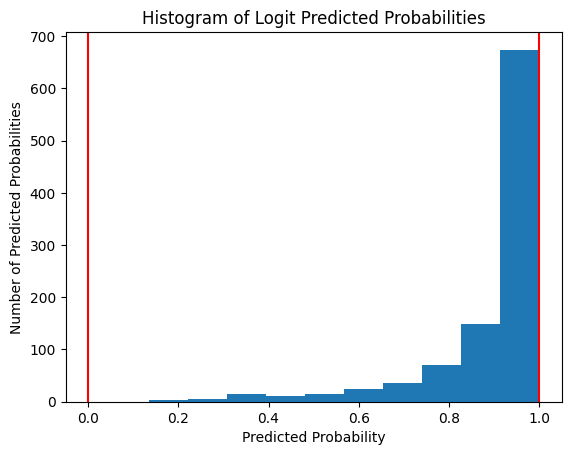

In [77]:
# histogram of predicted probabilities (logistic edition)

plt.hist(logit_pred)
plt.title("Histogram of Logit Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Number of Predicted Probabilities")
plt.axvline(0, color = 'red')
plt.axvline(1, color = 'red')

##### A5: Prediction for New Customers

In [78]:
# New customers
new_customers = pd.DataFrame({
'Age': [25, 35, 45, 55],
'Income': [30, 50, 70, 90],
'TimeOnSite': [2, 5, 8, 10]
})

In [79]:
# use logit_model to predict values for these new customers

new_customers = sm.add_constant(new_customers)
new_pred = logit_model.predict(new_customers)

In [80]:
new_pred

0    0.371500
1    0.942887
2    0.997836
3    0.999898
dtype: float64

In [81]:
new_customers["PredictedProbability"] = new_pred

In [86]:
# getting classification value into the table

new_customers["Classification"] = (new_customers["PredictedProbability"] > 0.5).astype(int)

In [91]:
# dropping the constant since we don't need it anymore, make table clean

new_customers.drop(columns = "const")

,Age,Income,TimeOnSite,PredictedProbability,Classification
0,25,30,2,0.371500,0
1,35,50,5,0.942887,1
2,45,70,8,0.997836,1
3,55,90,10,0.999898,1


Based on the table above, the customer at index 3 is most likely to purchase. This is likely due to the fact that they have the highest overall statistics for all three predictors: Age, Income, and TimeOnSite. Since the logistic regression coefficients were all positive, indicating that the log-odds of purchase increase as the variable values increase, it makes sense that the oldest customer with the highest income and highest time spent on the site would be the most likely to purchase.

#### Part B: Time Series Analysis

##### B1: Time Series Visualization

Text(0.5, 1.0, 'Time Series of Daily Sales (1/2024 to 12/2025)')

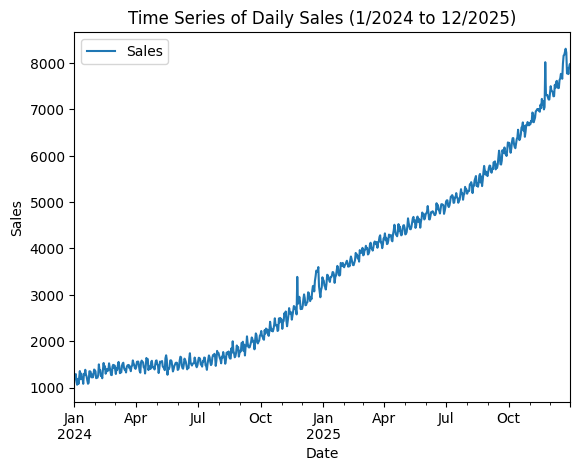

In [96]:
# plot time series

ax = df_sales.plot(y = "Sales")
ax.set_ylabel("Sales")
ax.set_title("Time Series of Daily Sales (1/2024 to 12/2025)")

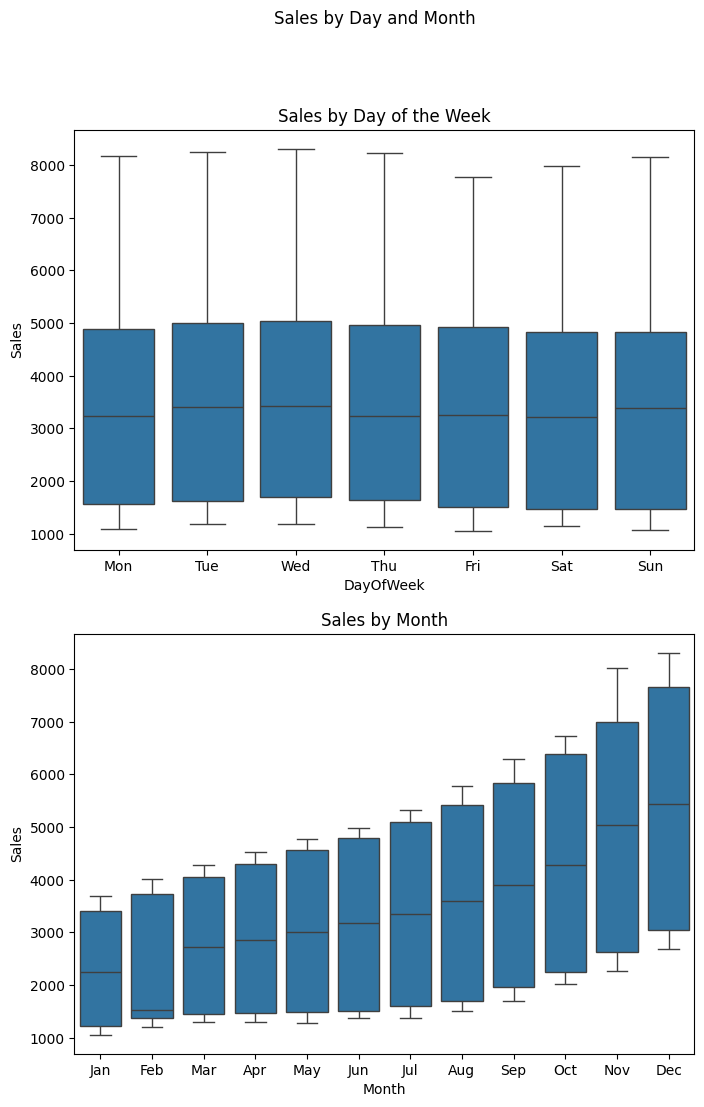

In [112]:
# seasonal subseries boxplots using seaborn

fig, axs = plt.subplots(
    2, 1,
    figsize=(8, 12),
    sharex=False
)

fig.suptitle("Sales by Day and Month")
sns.boxplot(x = "DayOfWeek", y = "Sales", data = df_sales, ax = axs[0])
sns.boxplot(x = "Month", y = "Sales", data = df_sales, ax = axs[1])
axs[0].set_title("Sales by Day of the Week")
axs[0].set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
axs[1].set_title("Sales by Month")
axs[1].set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

In [113]:
# calculate the means by day and by month

mean_by_day = df_sales.groupby("DayOfWeek")["Sales"].mean()
mean_by_month = df_sales.groupby("Month")["Sales"].mean()

In [115]:
print(mean_by_day)
print(mean_by_month)

DayOfWeek
0    3522.599490
1    3596.691932
2    3621.393352
3    3534.350202
4    3462.561654
5    3421.208956
6    3445.002365
Name: Sales, dtype: float64
Month
1     2327.495873
2     2540.578679
3     2743.556341
4     2898.688875
5     3022.607163
6     3164.054542
7     3346.561515
8     3580.811846
9     3924.311042
10    4344.178190
11    4838.293918
12    5396.124950
Name: Sales, dtype: float64


While sales are pretty consistent when plotted by day of the week, indicating that customers don't have a preference for what day to shop, we notice an overall upwards trend with sales over the course of a year. And over the course of the two years in the time series, the number of sales continues to trend upwards year over year. This can be seen both through the means (the mean number of sales per days of the week are very similar to each other whereas there is a noticeable upwards trend in mean number of sales per month as the year progresses) and the boxplots. The general upwards trend can be seen in the visualization of the time series.

##### B2: Stationarity Assessment

In [116]:
# get the rolling mean and rolling std

roll_mean = df_sales["Sales"].rolling(window=30).mean()
roll_std = df_sales["Sales"].rolling(window=30).std()

Text(0.5, 1.0, '30-Day Rolling Standard Deviation')

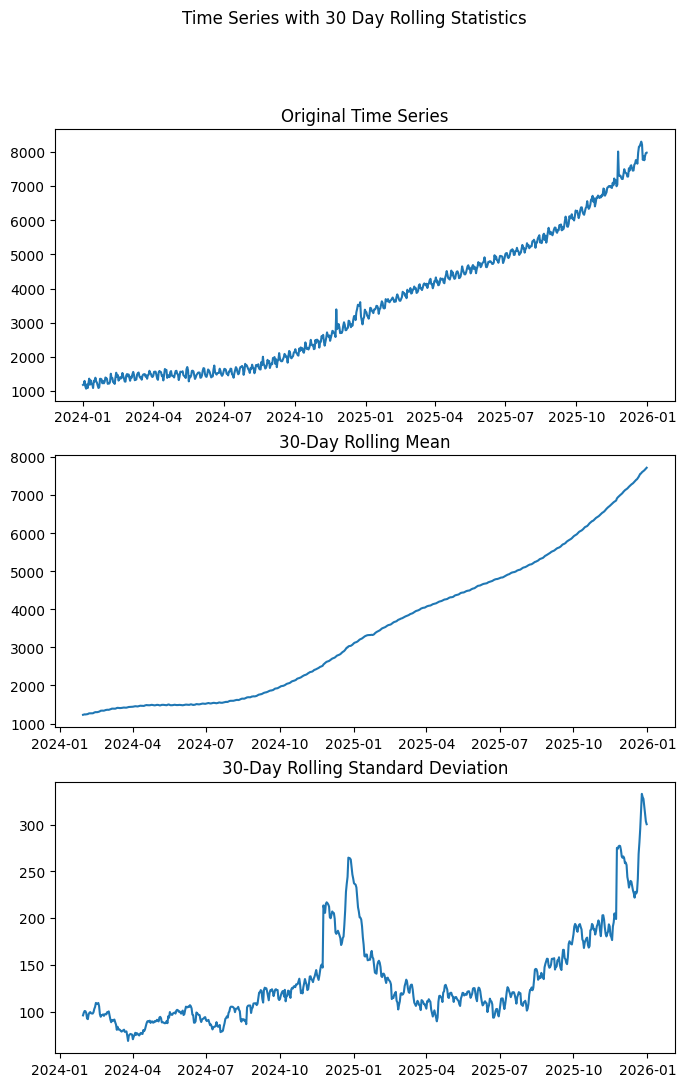

In [119]:
# the series, rolling mean, and rolling std

fig, axs = plt.subplots(
    3, 1,
    figsize=(8, 12),
    sharex=False
)

fig.suptitle("Time Series with 30 Day Rolling Statistics")

# plot original series, then rolling mean, then rolling std

axs[0].plot(df_sales.index, df_sales["Sales"])
axs[0].set_title("Original Time Series")
axs[1].plot(df_sales.index, roll_mean)
axs[1].set_title("30-Day Rolling Mean")
axs[2].plot(df_sales.index, roll_std)
axs[2].set_title("30-Day Rolling Standard Deviation")

The series is not stationary. As we can see from the graphs above, both the mean and the variance change over time and are not constant.

In [122]:
# separate out first six months and last six months from the data

first_half = df_sales.loc['2024-01-01' : '2024-06-01']
last_half = df_sales.loc['2025-06-01' : '2025-12-31']

In [125]:
# calculate the mean and std for both halves and print

print("First 6 Months Sales:\n")
print(f"Mean: {first_half["Sales"].mean()}")
print(f"Std: {first_half["Sales"].std()}")
print("\nLast 6 Months Sales:\n")
print(f"Mean: {last_half["Sales"].mean()}")
print(f"Std: {last_half["Sales"].std()}")

First 6 Months Sales:

Mean: 1400.8199135653851
Std: 132.63150138564794

Last 6 Months Sales:

Mean: 6063.545140038723
Std: 1001.3253631610607


##### B3: Autocorrelation Analysis

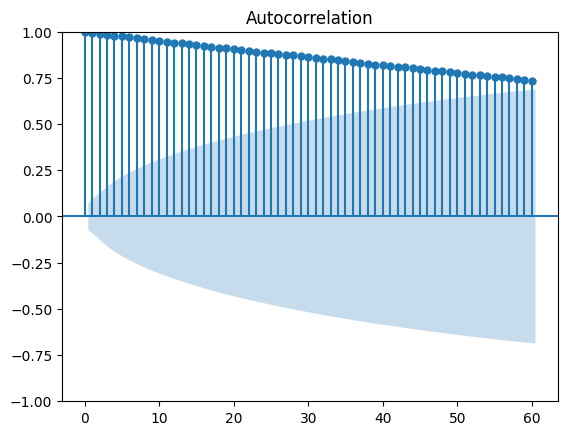

In [140]:
# plot acf for up to 60 lags

plot_acf(x = df_sales["Sales"], lags = 60).show()

In [131]:
# get just the values of sales to use in the function

sales_val = df_sales["Sales"].values

In [133]:
# calculate autocorrelations for lag 1, lag 7, and lag 30

lag1 = np.corrcoef(sales_val[1:], sales_val[:-1])[0,1]
lag7 = np.corrcoef(sales_val[7:], sales_val[:-7])[0,1]
lag30 = np.corrcoef(sales_val[30:], sales_val[:-30])[0,1]

In [134]:
print("Autocorrelations with different lags:\n")
print(f"Lag 1: {lag1}")
print(f"Lag 7: {lag7}")
print(f"Lag 30: {lag30}")

Autocorrelations with different lags:

Lag 1: 0.9982409625549881
Lag 7: 0.9980857988104597
Lag 30: 0.9954574959528383


The autocorrelations seem to be similar regardless of the length of lag and are relatively persistent, given that they are positive values.

##### B4: STL Decomposition

In [135]:
# apply STL decomp with weekly seasonality

stl = STL(df_sales['Sales'], seasonal=7, robust=True)
result = stl.fit()

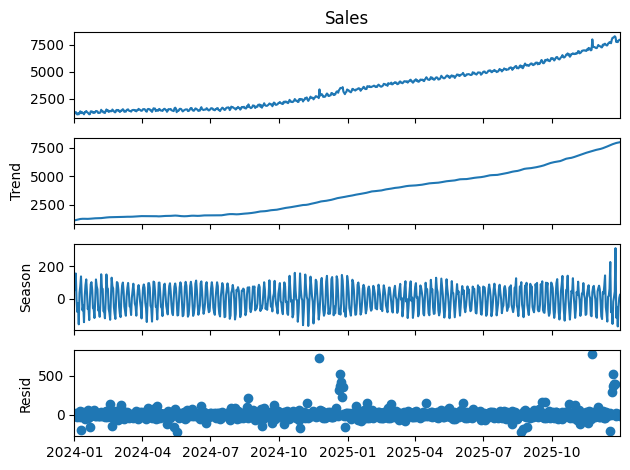

In [141]:
result.plot().show()

Trend:

Overall, sales are trending upwards over time.

Seasonal:

Sales remain pretty constant on a weekly basis and don't display any particular patterns. This is consistent with what we saw during the visualization phase as well.

Remainder:

We do notice some variance in the remainders around the holiday season (November and December) and we can assume that these are due to special events like Black Friday and Christmas.

##### B5: Remainder Diagnostics

In [142]:
# extract the remainder

remainder = result.resid

Text(0.5, 1.0, 'ACF')

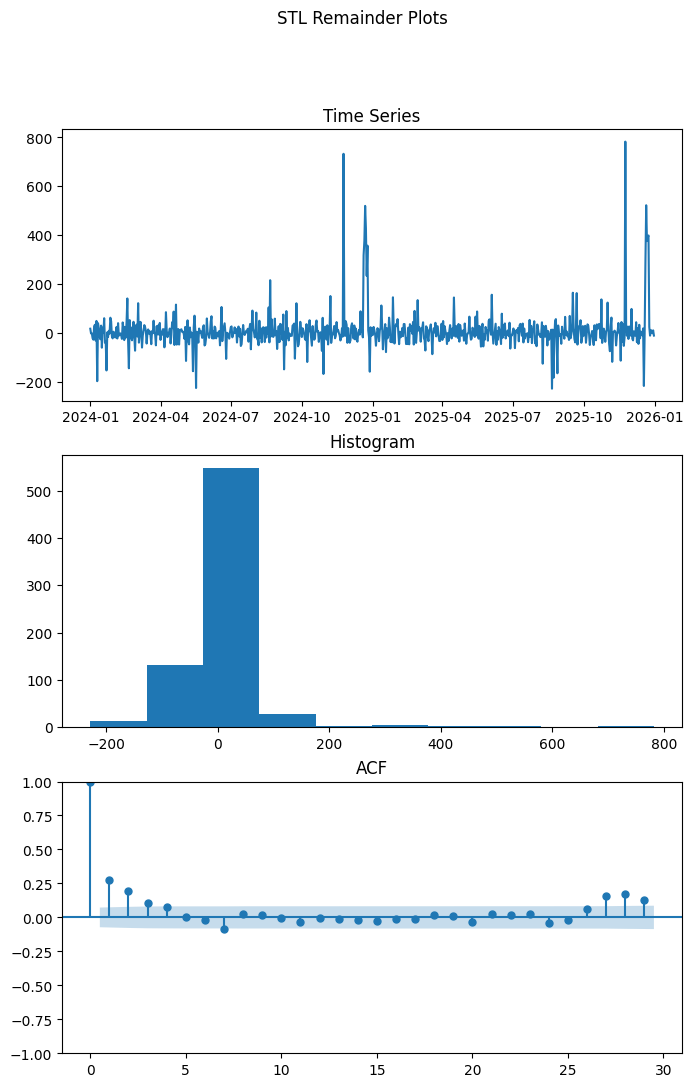

In [144]:
# plot the remainder

fig, axs = plt.subplots(
    3, 1,
    figsize=(8, 12),
    sharex=False
)

fig.suptitle("STL Remainder Plots")

# plot original series, then rolling mean, then rolling std

axs[0].plot(remainder)
axs[0].set_title("Time Series")
axs[1].hist(remainder)
axs[1].set_title("Histogram")
plot_acf(remainder, ax = axs[2])
axs[2].set_title("ACF")

In [149]:
# statistics

print("STL Remainder Statistics\n")
print(f"Mean: {remainder.mean()}")
print(f"Std: {remainder.std()}")

STL Remainder Statistics

Mean: 7.293252976181948
Std: 76.37603793684745


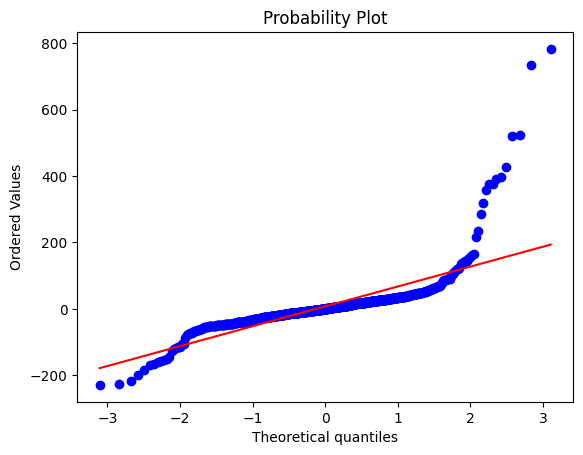

In [150]:
# plot to check normality

stats.probplot(remainder, dist = "norm", plot = plt)
plt.show()

It appears roughly to adhere to normal distribution.

In [151]:
# find dates where remainder is greater than 3x the std

threshold = 3 * remainder.std()
outliers = remainder[remainder.abs() > threshold]

In [152]:
outliers

Date
2024-11-24    732.554987
2024-12-20    317.318442
2024-12-21    376.446779
2024-12-22    519.284422
2024-12-23    427.442988
2024-12-24    233.104196
2024-12-25    356.622087
2025-11-24    782.352491
2025-12-20    286.460840
2025-12-21    521.918353
2025-12-22    375.150675
2025-12-23    390.683588
2025-12-24    398.228276
Name: resid, dtype: float64

In both 2024 and 2025, Black Friday (11/24) and Christmas (12/20 through 12/25) are outliers in terms of the number of sales, as we can clearly see in the printed dates of outliers above.